In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re
from wordcloud import WordCloud
from collections import Counter
import tensorflow as tf
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = pd.read_csv("../data/train.tsv", sep="\t", encoding = "utf-8", header=None)
test_df = pd.read_csv("../data/test.tsv", sep="\t", encoding = "utf-8", header=None)
dev_df = pd.read_csv("../data/dev.tsv", sep="\t", encoding = "utf-8", header=None)

train_df.columns = ['text', 'emotions', 'id']
test_df.columns = ['text', 'emotions', 'id']
dev_df.columns = ['text', 'emotions', 'id']

In [3]:
train_df['emotions'] = list(map(lambda s : list(map(int, s.split(','))), train_df['emotions']))
test_df['emotions'] = list(map(lambda s : list(map(int, s.split(','))), test_df['emotions']))
dev_df['emotions'] = list(map(lambda s : list(map(int, s.split(','))), dev_df['emotions']))

In [4]:
train_df.head()

,text,emotions,id
0,My favourite food is anything I didn't have to...,[27],eebbqej
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj


In [5]:
def emotions_to_ekman(df):
    # anger disgust fear joy sadness surprise neutral
    ekman = [3, 3, 0, 0, 3, 3, 5, 5, 3, 4, 0, 1, 4, 3, 2, 3, 4, 3, 3, 2, 3, 3, 5, 3, 4, 4, 5, 6]
    res = []

    for i in df['emotions']:
        tmp = [0, 0, 0, 0, 0, 0, 0]
        for j in i:
            tmp[ekman[j]] = 1
        res.append(tmp)
    tmp_df = pd.DataFrame(res, columns=['angry', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'])
    
    return tmp_df

In [6]:
def emotions_to_categorical(df):
    ems = """
        admiration
        amusement
        anger
        annoyance
        approval
        caring
        confusion
        curiosity
        desire
        disappointment
        disapproval
        disgust
        embarrassment
        excitement
        fear
        gratitude
        grief
        joy
        love
        nervousness
        optimism
        pride
        realization
        relief
        remorse
        sadness
        surprise
        neutral
    """
    res = []

    for i in df['emotions']:
        tmp = [0 for _ in range(28)]
        for j in i:
            tmp[j] = 1
        res.append(tmp)
    tmp_df = pd.DataFrame(res, columns=ems.split())
    
    return tmp_df

In [7]:
train_df = pd.concat([train_df, emotions_to_categorical(train_df)], axis=1)
test_df = pd.concat([test_df, emotions_to_categorical(test_df)], axis=1)
dev_df = pd.concat([dev_df, emotions_to_categorical(dev_df)], axis=1)

In [9]:
train_df = train_df.drop(columns=['emotions', 'id'])
test_df = test_df.drop(columns=['emotions', 'id'])
dev_df = dev_df.drop(columns=['emotions', 'id'])

In [10]:
train_df.head()

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,To make her feel threatened,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Dirty Southern Wankers,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
train_df.to_csv('../data/train_ekman.csv')
test_df.to_csv('../data/test_ekman.csv')
dev_df.to_csv('../data/dev_ekman.csv')

In [45]:
train_df = pd.read_csv('../data/train_ekman.csv')
test_df = pd.read_csv('../data/test_ekman.csv')
dev_df = pd.read_csv('../data/dev_ekman.csv')

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
model_name = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

num_labels = 28
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.to(device)

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\biz\.cache\huggingface\hub\models--bert-base-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP downloa

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# 학습된 모델 및 토크나이저 불러오기
load_directory = "./model_saved_bert_base_v2"

model = AutoModelForSequenceClassification.from_pretrained(load_directory)
tokenizer = AutoTokenizer.from_pretrained(load_directory)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model.to(device)

In [ ]:
ems = """
        admiration
        amusement
        anger
        annoyance
        approval
        caring
        confusion
        curiosity
        desire
        disappointment
        disapproval
        disgust
        embarrassment
        excitement
        fear
        gratitude
        grief
        joy
        love
        nervousness
        optimism
        pride
        realization
        relief
        remorse
        sadness
        surprise
        neutral
    """
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        text = str(self.data.loc[index, 'text'])
        labels = self.data.loc[index, ems.split()].values
        labels = labels.astype('float32')
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        
        return item


In [11]:
MAX_LEN = 512
BATCH_SIZE = 32

train_dataset = EmotionDataset(train_df, tokenizer, MAX_LEN)
test_dataset = EmotionDataset(test_df, tokenizer, MAX_LEN)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for batch in train_loader:
    print(batch)
    break

{'input_ids': tensor([[  101,  1252,   164,  ...,     0,     0,     0],
        [  101, 16068,  2523,  ...,     0,     0,     0],
        [  101, 20394, 14350,  ...,     0,     0,     0],
        ...,
        [  101,  2431,   164,  ...,     0,     0,     0],
        [  101,  2091,   146,  ...,     0,     0,     0],
        [  101,  1337,  1281,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([[0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 

In [12]:
from tqdm import tqdm

In [ ]:
# optimizer 설정
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# 학습 시작
model.train()
epoch_num = 3
for epoch in range(epoch_num):
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epoch_num}')
    total_loss = 0
    
    for batch in progress_bar:
        # DataLoader가 반환하는 딕셔너리의 키를 올바르게 접근
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        # 라벨 컬럼을 'labels' 키로 묶어 전달
        # 데이터셋 클래스에서 이 부분 처리를 해야 함 (이전 답변 참조)
        labels = batch['labels'].to(device)

        # model의 출력
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        # 손실 계산 및 역전파
        # AutoModelForSequenceClassification은 'problem_type'이 'multi_label_classification'이면
        # 자동으로 Binary Cross-Entropy Loss를 계산하여 outputs.loss에 담습니다.
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Progress bar 업데이트
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epoch_num} completed! Average Loss: {avg_loss:.4f}")

Epoch 1/3: 100%|██████████| 1357/1357 [5:22:05<00:00, 14.24s/it, loss=0.2748]    


Epoch 1/3 completed! Average Loss: 0.2475


Epoch 2/3:   4%|▍         | 60/1357 [14:01<16:05:58, 44.69s/it, loss=0.2555]

In [ ]:
# 저장할 디렉토리 경로 지정
save_directory = "./model_saved_bert_base"

# 모델과 토크나이저 저장
model.save_pretrained(save_directory, from_pt=True)
tokenizer.save_pretrained(save_directory, from_pt=True)

('./model_saved\\tokenizer_config.json',
 './model_saved\\special_tokens_map.json',
 './model_saved\\vocab.txt',
 './model_saved\\added_tokens.json',
 './model_saved\\tokenizer.json')

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_recall_curve

def evaluate_model(model, test_loader, device, emotion_names = ['angry', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']):
    """
    다중 라벨 분류 모델을 평가하는 통합 함수.
    정확도, F1-점수를 계산하고, 각 라벨에 대한 개별 Precision-Recall 곡선을 그립니다.
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            probs = torch.sigmoid(logits)
            predictions = (probs > 0.5).int()

            all_predictions.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    all_predictions = np.vstack(all_predictions)
    all_labels = np.vstack(all_labels)
    all_probs = np.vstack(all_probs)

    accuracy = accuracy_score(all_labels, all_predictions)
    
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='micro'
    )
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='macro'
    )
    
    precision_per_label, recall_per_label, f1_per_label, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average=None
    )

    precision_macro_std = np.std(precision_per_label)
    recall_macro_std = np.std(recall_per_label)
    f1_macro_std = np.std(f1_per_label)

    print("--- 모델 평가 결과 ---")
    print(f"전체 샘플에 대한 정확도 (Exact Match Accuracy): {accuracy:.4f}")
    print("\n--- Micro 평균 지표 ---")
    print(f"Precision (Micro): {precision_micro:.4f}")
    print(f"Recall (Micro): {recall_micro:.4f}")
    print(f"F1-Score (Micro): {f1_micro:.4f}")
    print("\n--- Macro 평균 지표 ---")
    print(f"Precision (Macro): {precision_macro:.4f}")
    print(f"Recall (Macro): {recall_macro:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    
    print("\n--- 라벨별 지표 ---")
    for i in range(len(emotion_names)):
        print(f"{emotion_names[i]} - Precision: {precision_per_label[i]:.4f}, Recall: {recall_per_label[i]:.4f}, F1-Score: {f1_per_label[i]:.4f}")
    
    print(f"\nPrecision (Macro) 표준편차: {precision_macro_std:.4f}")
    print(f"Recall (Macro) 표준편차: {recall_macro_std:.4f}")
    print(f"F1-Score (Macro) 표준편차: {f1_macro_std:.4f}")
    
    # 각 감정별 Precision-Recall 곡선 그리기
    n_classes = all_labels.shape[1]
    for i in range(n_classes):
        plt.figure(figsize=(6, 5))
        
        precision_curve, recall_curve, _ = precision_recall_curve(all_labels[:, i], all_probs[:, i])
        
        plt.plot(recall_curve, precision_curve, label=f'{emotion_names[i]}')
        plt.plot([0, 1], [1, 0], linestyle='--', color='gray')
        plt.xlabel('재현율 (Recall)')
        plt.ylabel('정밀도 (Precision)')
        plt.title(f'정밀도-재현율 곡선: {emotion_names[i]}')
        plt.grid(True)
        plt.legend()
        plt.show()

    return accuracy, f1_micro, f1_macro

--- 모델 평가 결과 ---
전체 샘플에 대한 정확도 (Exact Match Accuracy): 0.6025

--- Micro 평균 지표 ---
Precision (Micro): 0.7189
Recall (Micro): 0.6479
F1-Score (Micro): 0.6816

--- Macro 평균 지표 ---
Precision (Macro): 0.7126
Recall (Macro): 0.5379
F1-Score (Macro): 0.5975

--- 라벨별 F1-점수 ---
  - angry: 0.5382
  - disgust: 0.3704
  - fear: 0.6821
  - joy: 0.8185
  - sadness: 0.5545
  - surprise: 0.5674
  - neutral: 0.6516


c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

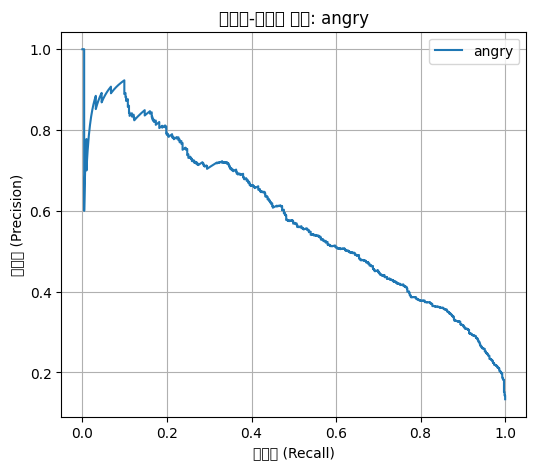

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

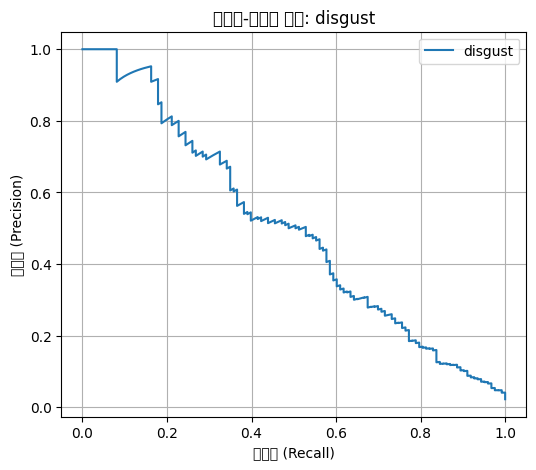

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

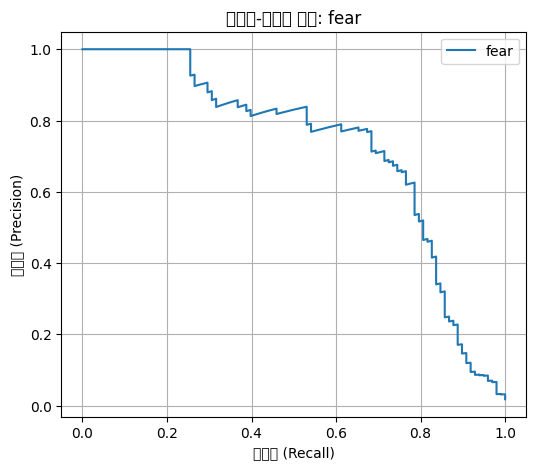

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

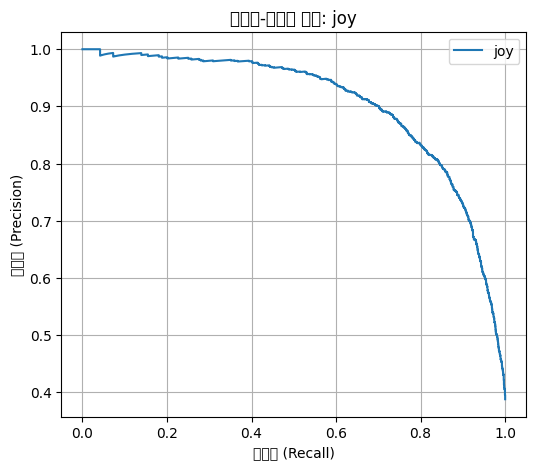

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

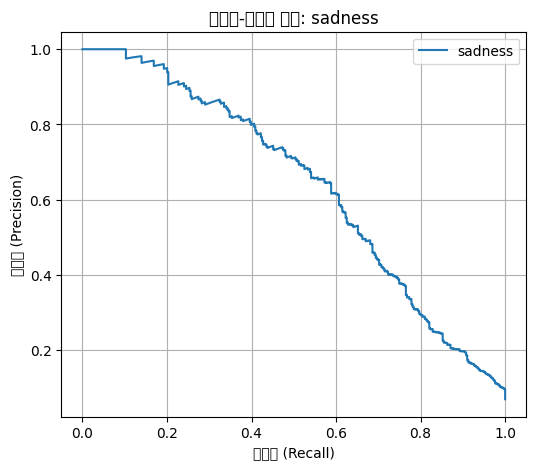

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

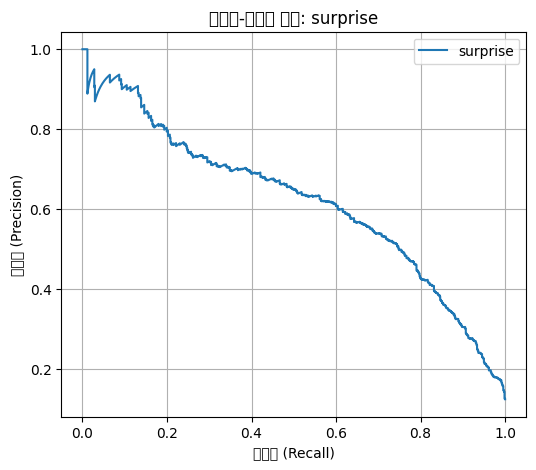

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

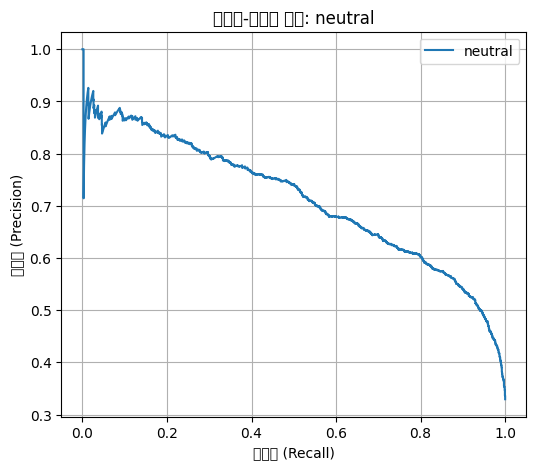

In [52]:
accuracy, f1_micro, f1_macro = evaluate_model(model, test_loader, device)